# **Setup**

Let us first import some required libraries.

In [42]:
from torchvision.models import vgg19
from torch import nn
from torchvision.models.feature_extraction import create_feature_extractor
import torch
from collections import defaultdict
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
import argparse
import matplotlib.pyplot as plt
from PIL import Image
import os
import logging

Setting up the device. We can make use of a GPU if available or else we run it on CPU.

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

##Hyperparameters
We have to set some important hyperparameters that we'll use for running the model

In [44]:
output_image_path = '/content/content.jpg'
style_image_path = '/content/style.jpg'
content_image_path = '/content/content.jpg'
epochs = 100
alpha = 1
beta = 1e5
lr = 1e-2
saved_dir_path = '/content/'

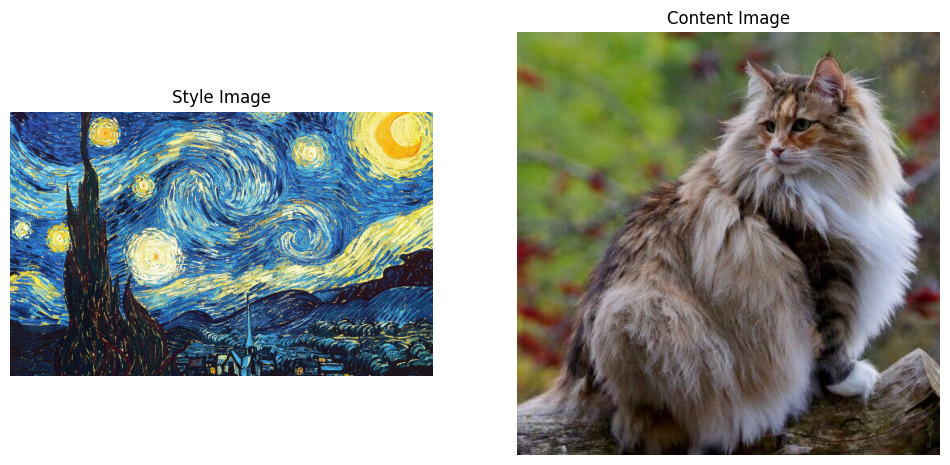

In [45]:
# Load images
style_image = Image.open(style_image_path)
content_image = Image.open(content_image_path)

# Plotting
plt.figure(figsize=(12, 6))

# Plot style image
plt.subplot(1, 2, 1)
plt.imshow(style_image)
plt.title('Style Image')
plt.axis('off')

# Plot content image
plt.subplot(1, 2, 2)
plt.imshow(content_image)
plt.title('Content Image')
plt.axis('off')


plt.show()

We are going to be using a pretrained VGG 19 model for this task. We can see the model architecture below. We are going to take the features from the MaxPool at the end of each Convolution block for the style transfer. The extracted features from the MaxPool layers will serve as our style representation. These layers capture hierarchical and abstract features in the image, making them suitable for defining the artistic style of the reference image. The chosen MaxPool layers typically mark the end of each convolutional block, ensuring a balance between capturing fine details and preserving high-level features. This approach aligns with the use of feature correlations in the Gram matrix, which is fundamental to the style transfer process.

For content features, we will extract information from a specific Convolutional layer.
The choice of this layer strikes a balance between capturing detailed content information
and avoiding overly fine-grained details. The content features will be extracted from
the output of a Convolutional layer located within the architecture.


This aligns with the traditional use of feature correlations in the Gram matrix, a key
component in the calculation of style loss during the style transfer process.

In [46]:
vgg = vgg19()
features = vgg.features
for item in features:
  print(item)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True

Defining our pretrained network for style transfer.

In [47]:
class VGG19(nn.Module):
    def __init__(self):
        super().__init__()

        self.vgg19 = vgg19(weights='IMAGENET1K_V1').features

        self.max_pool_layers = [4, 9, 18, 27]

        for param in self.vgg19.parameters():
            param.requires_grad_(False)

        for idx, module in enumerate(self.vgg19):
            if hasattr(module, 'inplace'):
                self.vgg19[idx].inplace = False
            if idx in self.max_pool_layers:
                self.vgg19[idx] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.model = create_feature_extractor(self.vgg19, {
            '1': 'conv1_1',
            '6': 'conv2_1',
            '11': 'conv3_1',
            '20': 'conv4_1',
            '29': 'conv5_1',
        })

    def forward(self, x):
        output = self.model(x)
        return output

##Defining the loss function

This `StyleTransferLoss` class defines a custom loss function for neural style transfer. The class extends the PyTorch `nn.Module` and is initialized with two hyperparameters, `alpha` and `beta`, which represent the weights assigned to the content and style losses, respectively. The class uses the Mean Squared Error (MSE) loss for content loss calculations.

The `gram_matrices` method computes the Gram matrix for each layer in the style representations. Gram matrices capture style information by representing the correlations between feature maps, crucial for assessing the stylistic content of an image.

The `flatten_representation` method flattens the feature maps of each layer in a given representation. This is essential for computing the Gram matrices, as it transforms the spatial information of each feature map into a vector.

The `forward` method calculates the overall loss. It starts by computing the content loss between the input and content representations. Then, it generates Gram matrices for both the input and style representations using the previously defined methods. The style loss is computed by comparing the Gram matrices, and the final loss is a combination of the content and style losses, where the style loss is normalized by the size of the Gram matrix. This custom loss function can be used as the objective function during the training of a neural style transfer model to optimize the generated image for both content preservation and artistic style.

In [48]:
class StyleTransferLoss(nn.Module):
    def __init__(self, alpha, beta):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.mse_loss = nn.MSELoss()

    def gram_matrices(self, style_representations):
        gram_matrices_representation = defaultdict()
        for layer_name, filter in style_representations.items():
            filter_trans = torch.transpose(filter, 0, 1)
            gram_matrices_representation[layer_name] = torch.matmul(filter, filter_trans)
        return gram_matrices_representation

    def flatten_representation(self, representation):
        flattened_representation = defaultdict()
        for layer_name, filter in representation.items():
            flattened_representation[layer_name] = torch.flatten(filter, start_dim=1)
        return flattened_representation

    def forward(self, input_representation, content_representation, style_representation):
        loss = self.alpha * self.mse_loss(input_representation['conv4_1'], content_representation['conv4_1'])
        input_grams = self.gram_matrices(self.flatten_representation(input_representation))
        style_grams = self.gram_matrices(self.flatten_representation(style_representation))

        for input_gram, style_gram in zip(input_grams.values(), style_grams.values()):
            loss += self.beta * self.mse_loss(input_gram, style_gram) / (input_gram.shape[0] ** 2) / (input_gram.shape[1] ** 2)

        return loss

In [49]:
def tensor_to_image(tensor):
  img = (255 * tensor).cpu().detach().squeeze(0).numpy()
  img = img.clip(0, 255).transpose(1, 2, 0).astype("uint8")
  return Image.fromarray(img)

def image_to_tensor(image):
  # Transform to tensor
  image = transforms.ToTensor()(image)
  # Fake batch dimension required to fit network's input dimensions
  image = image.unsqueeze(0)
  # Move to the right device and convert to float
  return image.to(device, torch.float)


In [50]:
def show_evolution(tensor, history=[], title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = tensor_to_image(image)
    # Display a big figure
    plt.rcParams['figure.figsize'] = [8, 5]
    plt.figure()
    # Image
    plt.subplot(121)
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    # Losses
    ax = plt.subplot(122)
    plt.yscale('log')
    plt.title('Losses')
    import numpy as np
    history = np.array(history).T
    plt.plot(history[0], label='Style')
    plt.plot(history[1], label='Content')
    plt.legend(loc="upper right")
    # Finaly show the graph
    plt.show()
    # Display a textual message
    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
        history[0][-1], history[1][-1]))

We define a `style_transfer` function that takes as input paths to the content image (`content`), style image (`style`), and the desired output image (`output`). The optimization process involves iteratively updating the output image (`output_img_tensor`) to minimize a loss function defined by the `StyleTransferLoss` class. The optimization is performed using the L-BFGS algorithm, and at each iteration (`epoch`), the loss is computed and logged. The final stylized images are saved at the specified directory (`saved_dir`) with filenames indicating the iteration number.

In [51]:
def style_transfer(output, content, style, epochs, alpha, beta, lr, saved_dir):
    model = VGG19()
    model.to(device)
    content_representation, style_representation = get_representations(model, content, style)

    output_img = read_img(output)
    output_img_tensor = transform_img(output_img).to(device)
    output_img_tensor.requires_grad_(True)

    criterion = StyleTransferLoss(alpha=alpha, beta=beta)
    optimizer = torch.optim.LBFGS([output_img_tensor], lr=lr)

    history = []  # Initialize a list to store loss history for plotting
    # show_evolution(output_img_tensor, history, title="Initial Image:")
    for i in range(epochs):

        def closure():
            output_representation = model(output_img_tensor)
            optimizer.zero_grad()

            loss = criterion(output_representation, content_representation, style_representation)
            loss.backward()
            logging.info(f'Epoch {i+1}/{epochs}, Loss: {loss.item()}')

            # Save the value of loss for plotting
            history.append([alpha * loss.item(), beta * loss.item(), 0.0, loss.item()])

            return loss

        optimizer.step(closure)

        img_path = os.path.join(saved_dir, f'output_{i+1}.jpg')
        logging.info(f'{img_path} saved')
        save_image(output_img_tensor, img_path)

        # Show evolution every 10 epochs
        if i==1 or (i + 1) % 10 == 0:
            show_evolution(output_img_tensor, history, title=f"Iteration {i+1}:")

The `get_representations` function takes the model (`model`), a content image path (`content`), and a style image path (`style`) as inputs. It reads and transforms the content and style images into tensors using the `read_img` and `transform_img` functions. These tensor representations are then obtained by passing them through the VGG19 model, capturing the feature representations of both the content and style images. The `read_img` function opens an image from a given file path, and the `transform_img` function applies a series of transformations, including resizing to (224, 224) pixels and converting the image to a PyTorch tensor.

In [52]:
def get_representations(model, content, style):
    content_img = read_img(content)
    content_img_tensor = transform_img(content_img).to(device)
    content_representation = model(content_img_tensor)

    style_img = read_img(style)
    style_img_tensor = transform_img(style_img).to(device)
    style_representation = model(style_img_tensor)

    return content_representation, style_representation

def read_img(img_path):
    return Image.open(img_path)

def transform_img(img):
    transformer = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    return transformer(img)

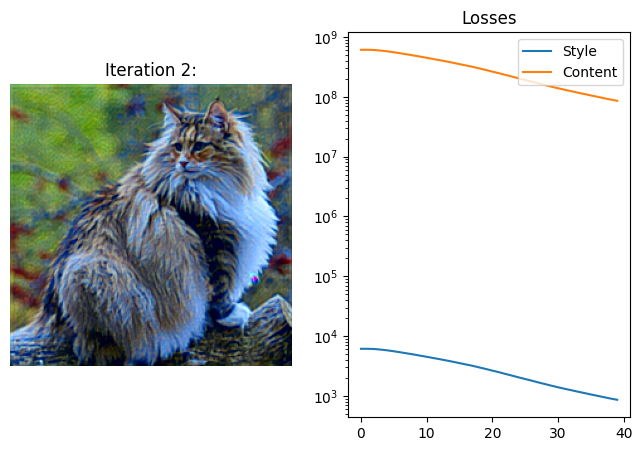

Style Loss : 859.447327 Content Loss: 85944732.666016


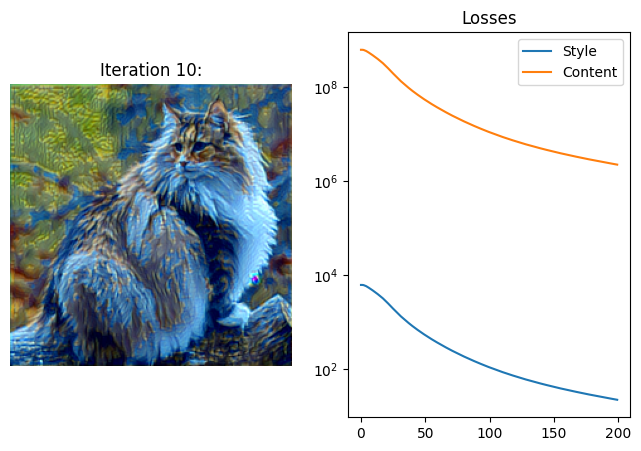

Style Loss : 22.130890 Content Loss: 2213088.989258


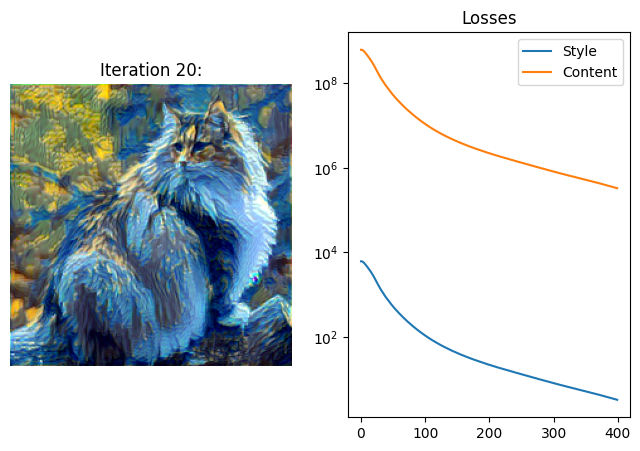

Style Loss : 3.274055 Content Loss: 327405.452728


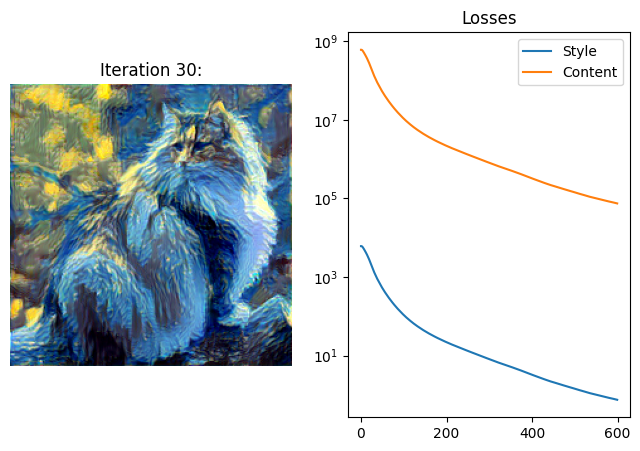

Style Loss : 0.749110 Content Loss: 74911.004305


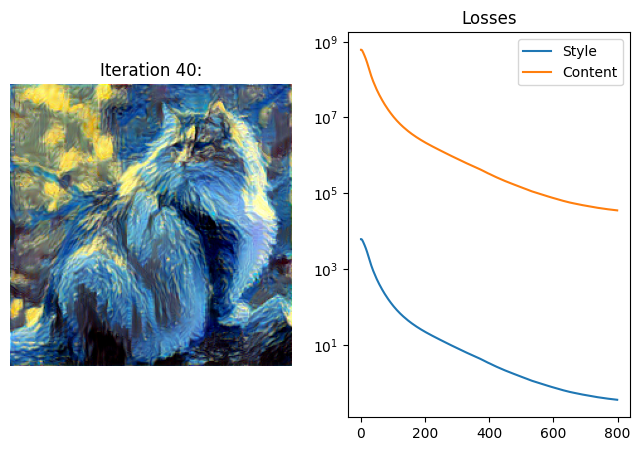

Style Loss : 0.352561 Content Loss: 35256.063938


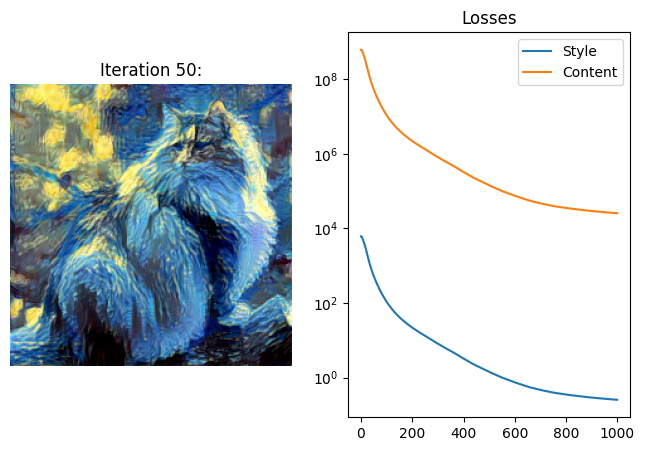

Style Loss : 0.254938 Content Loss: 25493.848324


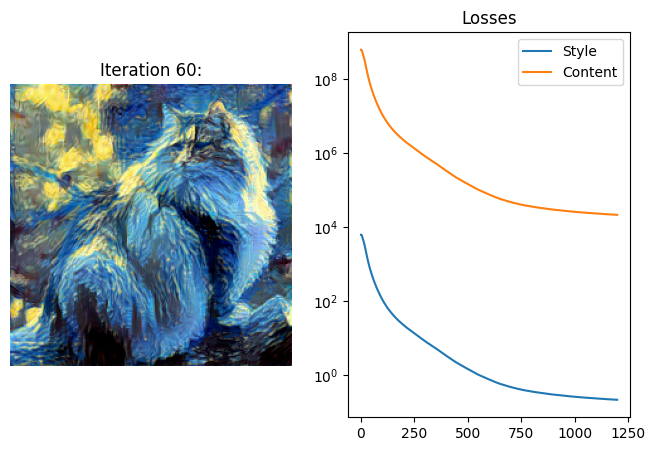

Style Loss : 0.211173 Content Loss: 21117.274463


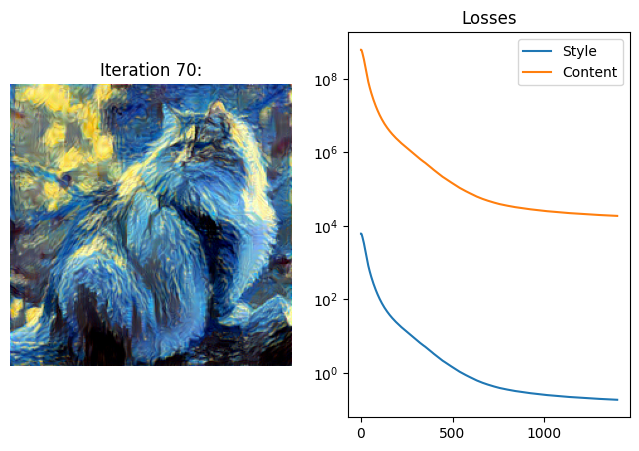

Style Loss : 0.186151 Content Loss: 18615.055084


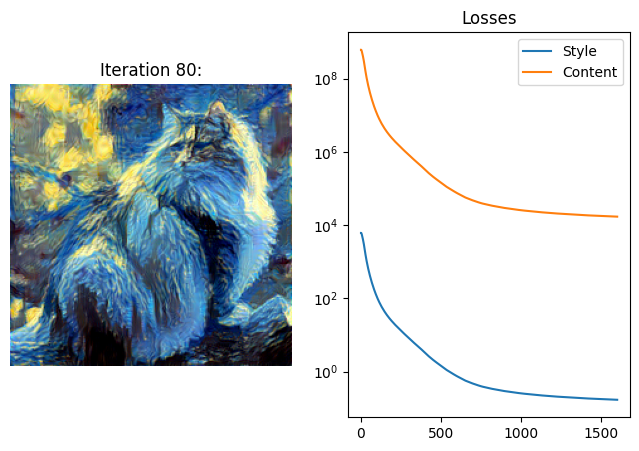

Style Loss : 0.170216 Content Loss: 17021.572590


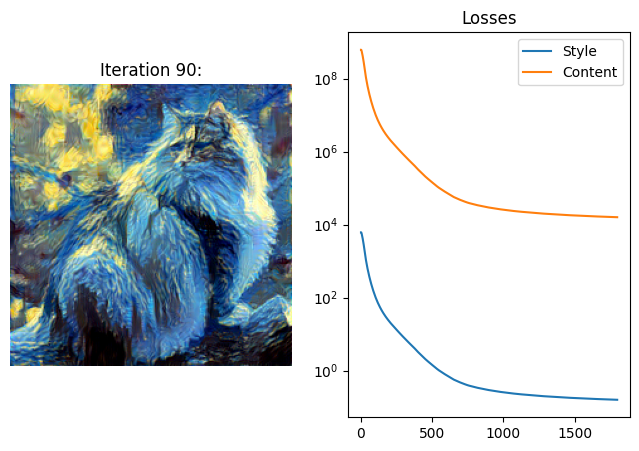

Style Loss : 0.159043 Content Loss: 15904.319286


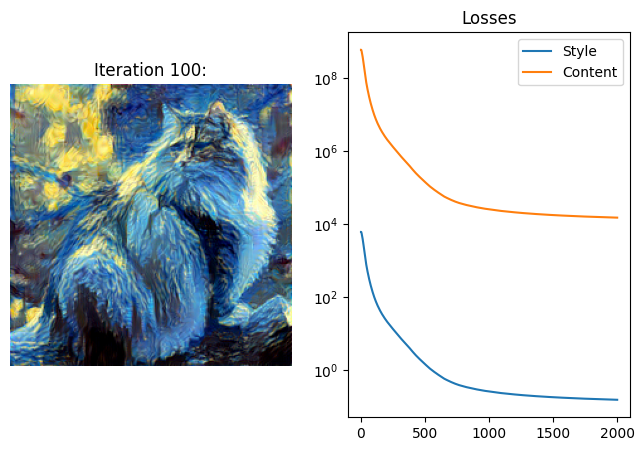

Style Loss : 0.150887 Content Loss: 15088.666975


In [53]:
style_transfer(output_image_path, content_image_path, style_image_path, epochs, alpha, beta, lr , saved_dir_path)

##Limitations and Improvement:

Though it has proven to be an efficient stylization technique, the applied approach of style transfer employing the VGG19 architecture is not without its limits. The model's sensitivity to hyperparameters, namely the weights given to the content and style losses (alpha and beta, respectively), is one of its main limitations. It can be difficult to manually adjust these hyperparameters for various datasets and styles, and the best stylization may not always be achieved. Furthermore, because the current model's training is limited to a particular collection of styles, it might have trouble generalizing to artistic genres that haven't been seen before. Some artworks might not be styled as faithfully as expected, so there is room for improvement in the authenticity of style adaption to new works.

There are a number of ways to improve the style transfer approach in order to overcome these drawbacks and raise its overall effectiveness. First, the susceptibility to manual hyperparameter modifications may be reduced by investigating automated hyperparameter tuning methods like grid search or random search. Adding a wider variety of artistic styles to the training dataset might help the model generalize to newly undiscovered styles. To enhance the process of adaptation and elevate stylistic accuracy, more sophisticated methods of style adaptation, such as the incorporation of adversarial training or reinforcement learning, should be investigated. Additionally, looking into model compression methods or lightweight designs may help to lessen computational difficulties and increase the style transfer model's suitability for deployment on a range of resource-constrained devices.

By systematically addressing these considerations, the style transfer method can be refined to exhibit greater robustness, adaptability, and fidelity across a broader spectrum of artistic styles.